# VAE - MNISTFashion

In [1]:
#Import bibliothèques
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style
import matplotlib
hdr_plot_style()

### Import data MnistFashion

In [2]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The train set contains 48000 images, in 375 batches
The test set contains 10000 images, in 79 batches


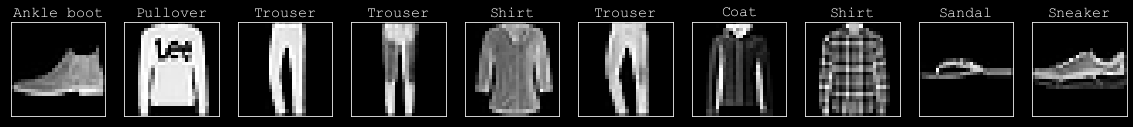

In [3]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Import Mnist

In [4]:
# Define data loading step
from torchvision.datasets import MNIST
from torchvision import transforms

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)



The train set contains 60000 images, in 235 batches
The test set contains 10000 images, in 40 batches


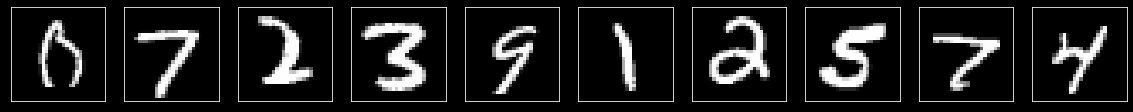

In [5]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
#classes_names = ['1', '8', '6', '4', '4', '1', '9', '2', '1', '5']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    #ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Implementation VAE

In [6]:
class AE(nn.Module):
    def __init__(self, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class VAE(AE):
    
    def __init__(self, encoding_dims, latent_dims, nin=28*28, n_latent = 2, n_hidden = 512, n_classes = 1):
        super(VAE, self).__init__(encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
        #Network Layers
        self.flatt = nn.Flatten()
        self.lin1 = nn.Linear(nin, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_hidden)
        self.lin3 = nn.Linear(n_hidden, n_hidden)
        
        self.lin4 = nn.Linear(n_latent, n_hidden)
        self.lin5 = nn.Linear(n_hidden, n_hidden)
        self.lin6 = nn.Linear(n_hidden, nin*n_classes)
        self.sigm = nn.Sigmoid()
        
    def encoder(self, x_in):
        x1 = F.relu(self.lin1(self.flatt(x_in)))
        x2 = F.relu(self.lin2(x1))
        x3 = self.lin3(x2)
        return x3
        
    def decoder(self, x_in):
        x1 = F.relu(self.lin4(x_in))
        x2 = F.relu(self.lin5(x1))
        x_out = self.sigm(self.lin6(x2))
        return x_out
       
    def encode(self, x):
        x= self.encoder(x)
        mu=self.mu(x)
        sigma=self.sigma(x)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        n_batch=x.shape[0]
        mu, sigma =z_params
        
        #reparamétrisation
        q=distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z=(sigma*q.sample((int(n_batch), ))) + mu
        #compute KL divergence
        kl_div=0.5* torch.sum(1+sigma -torch.pow(mu, 2)- torch.exp(sigma))
        kl_div=kl_div/n_batch
        
        
        return z, kl_div

In [8]:
'''
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
   
    return encoder, decoder
    
'''

'\ndef construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):\n    # Encoder network\n    encoder = nn.Sequential(\n          nn.Flatten(),\n          nn.Linear(nin, n_hidden), nn.ReLU(),\n          nn.Linear(n_hidden, n_hidden), nn.ReLU(),\n          nn.Linear(n_hidden, n_hidden),\n    )\n    # Decoder network\n    decoder = nn.Sequential(\n          nn.Linear(n_latent, n_hidden), nn.ReLU(),\n          nn.Linear(n_hidden, n_hidden), nn.ReLU(),\n          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()\n    )\n   \n    return encoder, decoder\n    \n'

In [9]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='sum')

def compute_loss(model, x):
    x_tilde, kl_div=model(x)
    cross_ent=recons_criterion(x_tilde,x)
    logpx_z=cross_ent
    full_loss=torch.mean(logpx_z-kl_div)
    
    return full_loss

def train_step(model, x, optimizer):
    # Compute the loss.
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

### Train and test Model

In [10]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Build the VAE model
model = VAE(encoding_dims=n_hidden, latent_dims=n_latent, nin=nin, n_latent = 2, n_hidden = 512, n_classes = 1)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

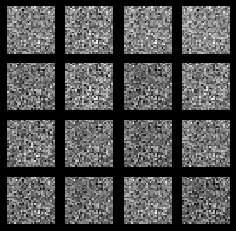

Epoch: 1, Test set ELBO: tensor([3010252.5000], grad_fn=<AddBackward0>)
Epoch: 2, Test set ELBO: tensor([2251953.2500], grad_fn=<AddBackward0>)
Epoch: 3, Test set ELBO: tensor([2088943.], grad_fn=<AddBackward0>)
Epoch: 4, Test set ELBO: tensor([1993180.1250], grad_fn=<AddBackward0>)
Epoch: 5, Test set ELBO: tensor([1934868.6250], grad_fn=<AddBackward0>)


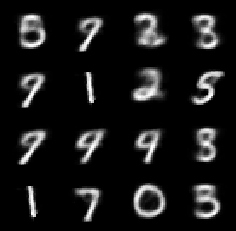

Epoch: 6, Test set ELBO: tensor([1889814.], grad_fn=<AddBackward0>)
Epoch: 7, Test set ELBO: tensor([1859771.7500], grad_fn=<AddBackward0>)
Epoch: 8, Test set ELBO: tensor([1835599.1250], grad_fn=<AddBackward0>)
Epoch: 9, Test set ELBO: tensor([1816986.2500], grad_fn=<AddBackward0>)
Epoch: 10, Test set ELBO: tensor([1803594.8750], grad_fn=<AddBackward0>)


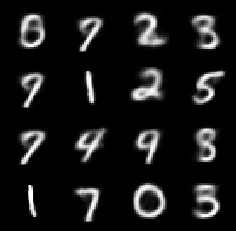

Epoch: 11, Test set ELBO: tensor([1790514.1250], grad_fn=<AddBackward0>)
Epoch: 12, Test set ELBO: tensor([1784694.1250], grad_fn=<AddBackward0>)
Epoch: 13, Test set ELBO: tensor([1765905.1250], grad_fn=<AddBackward0>)
Epoch: 14, Test set ELBO: tensor([1755855.5000], grad_fn=<AddBackward0>)
Epoch: 15, Test set ELBO: tensor([1742532.], grad_fn=<AddBackward0>)


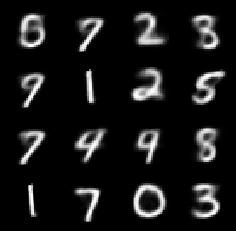

Epoch: 16, Test set ELBO: tensor([1738596.7500], grad_fn=<AddBackward0>)
Epoch: 17, Test set ELBO: tensor([1727912.7500], grad_fn=<AddBackward0>)
Epoch: 18, Test set ELBO: tensor([1723464.8750], grad_fn=<AddBackward0>)
Epoch: 19, Test set ELBO: tensor([1718765.6250], grad_fn=<AddBackward0>)
Epoch: 20, Test set ELBO: tensor([1707574.6250], grad_fn=<AddBackward0>)


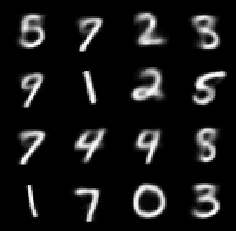

In [11]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epochs=20
test_sample = imgs_test[0:16, :, :, :]
generate_and_save_images(model, epochs, test_sample)
for epoch in range(1, epochs + 1):
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss += train_step(model, x, optimizer)
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
    if epoch%5 ==0 :
        generate_and_save_images(model, epoch, test_sample)

### Observation par zone de l'espace latent

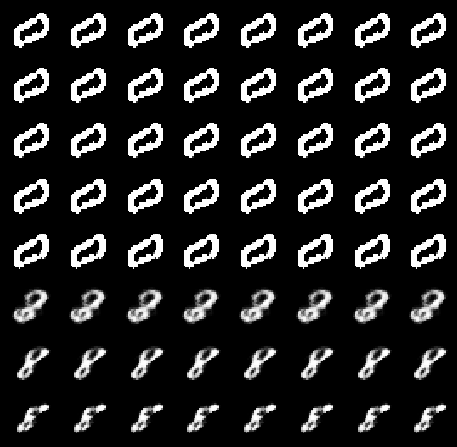

In [16]:
x = np.linspace(-50, 50, 10)
y = np.linspace(50, 50, 10)
fig = plt.figure(figsize=(10, 10))
for i in range(8):
    for j in range(8):
        plt.subplot(10,10, (i * 10) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

<generator object Module.parameters at 0x00000249C73293C8>

In [32]:
nin

784